# Open Library Subject Analysis from 1900s

## Abstract

This study leverages the Open Library dataset, containing 89,677,650 bibliographic records with metadata on subjects, publication dates, and geographic origins, to explore global publishing trends and subject distributions from the 1900s to the 2020s. Using Apache Spark and Apache Parquet for scalable data processing, the analysis examines publication volumes, country contributions, subject co-occurrences, and temporal trends in subject emergence. Key findings reveal a peak in publication output in the 2000s, dominance by the USA and UK, an average of 5.1 subjects per publication, and universal subjects like history appearing across 249 countries. The data was parsed into editions and expanded subject DataFrames, stored in Parquet format, and transformed by exploding nested arrays for granular analysis. This report demonstrates a pipeline for big data analysis to insights into cultural and intellectual trends in global publishing and recommendations for further research.


## Motivation and Problem Statement 

Books reflect the cultural and intellectual priorities of the societies in which they are published. However, analyzing such patterns at scale poses significant challenges. The OpenLibrary dataset, while rich in information, is vast and semi-structured, with key fields like subjects, dates, and locations stored in nested array formats. Extracting meaningful trends from this data requires a robust technical pipeline capable of handling large volumes of data, transforming complex structures, and supporting efficient querying and aggregation.

This project addresses these challenges by using PySpark and Parquet-based partitioning to preprocess and structure the data in a way that enables scalable analysis. The ultimate goal is to better understand how thematic relationships evolve in the published record—and to demonstrate the critical role of big data tools in making this type of cultural analysis possible at scale.

This project aims to uncover temporal and geographic trends in publication activity and subject diversity, addressing questions such as: 
- How have publication volumes evolved over time? Which countries drive global publishing?
- How do subjects co-occur?
- How do they vary by region and decade?

## Methodology

The methodology of this study follows a structured data processing pipeline designed to efficiently manage and analyze the scale and complexity of the OpenLibrary dataset. The pipeline consists of the following key stages:
1. **Data Ingestion and Initial Processing** - The dataset is loaded from its source and parsed into distinct components, specifically editions, works, and authors. This separation facilitates modular data handling and enables more efficient querying and transformation in subsequent steps.
2. **Parquet Storage and Partitioning** - The parsed data is converted into Apache Parquet format and partitioned by logical keys such as publication year and region. This step is critical for optimizing read performance and significantly reducing overall runtime during analysis.
3. **Data Transormation and Exploding Nested Fields** - To prepare the data for granular analysis, nested array fields are exploded. Each subject is represented as a separate row, and publish country fields are flattened and standardized to normalize the dataset and support consistent temporal and geographic aggregation.
4. **Trend and Pattern Analysis** - With the data cleaned and structured, subject pairings are extracted and analyzed over time and across regions. Visualizations and statistical summaries are generated to reveal patterns, identify emerging or declining themes, and explore regional differences in subject co-occurrence trends.

## Data Extraction and Processing
The Open Library dataset was sourced from a 41.89 GB compressed text file (`ol_cdump_latest.txt.gz`) at `/mnt/data/public/openlibrary/20250426/`. It was processed as follows:

### Data Loading
1. **Initialization**: A Spark session was initialized with `SparkSession.builder.appName("Open Library Dataframes Creation").master('local[*]').getOrCreate()`, utilizing all local cores.
2. **Reading**: The file was read as a text DataFrame using `spark.read.text(file_path)`, initially with one partition (`df.rdd.getNumPartitions()` returned 1).
3. **Splitting**: The text was split on tabs using `split(col("value"), "\t").alias("fields")`, creating columns: `record_type`, `key`, `revision`, `timestamp`, and `json_data`.
4. **Parsing**: The `json_data` column was parsed using a schema (`editions_json_schema`) with fields like `title`, `authors`, `subjects`, and `publish_country`, applied via `from_json(col("json_data"), editions_json_schema)`.
5. **Transformation**: The parsed DataFrame (`df_eds_final`) extracted fields like `edition_key`, `title`, `author_keys`, `language_keys`, `publish_country`, and `subjects`, using `transform` to simplify nested arrays (e.g., extracting author keys).

### Partitioning
1. **Output**: The transformed DataFrame was written to Parquet at `/partitioned_data/eds_partitioned/` using `df_eds_final.write.parquet`, resulting in 103 partitions. The editions Parquet files totaled 12.96 GB, with authors at 450.11 MB and works at 3.87 GB.
2. **Optimization**: Parquet’s columnar storage and partitioning by decade and country (in subsequent analyses) enhanced query performance and compression.

### Preprocessing
The editions DataFrame (`df_eds_final`) was further processed to create working DataFrames (`df_eds` and `df_explode`):
1. **Year Extraction**: A `year` column was derived using `regexp_extract(col("publish_date"), r"(\d{4})", 1)`, setting non-matching values to null.
2. **Decade Normalization**: A `decade` column was created with `concat((floor(col("year") / 10) * 10).cast("string"), lit("s"))` for years between 1900 and 2020, otherwise “Unknown”. The DataFrame was filtered to include only 1900–2020 records.
3. **Country Standardization**: The `publish_country` column was cleaned with `lower(regexp_replace(col("publish_country"), r"\s+", " "))` and joined with a broadcasted `country_mapping` DataFrame to standardize country names, defaulting to “Unknown” for unmapped values.
4. **Subject Cleaning**: The `subjects` column was transformed into `subjects_cleaned` by applying `trim(lower(regexp_replace(...)))` to remove commas, slashes, and extra spaces. A `subject_clean_flat` column was created by splitting subjects on commas and flattening arrays, followed by `subject_clean` to filter out invalid entries (e.g., “etc” or trailing spaces) using `array_distinct` and `spark_filter`. Rows with empty `subject_clean` arrays were excluded.
5. **Output**: The resulting `df_eds` (columns: `decade`, `country`, `subject_clean`) was written to Parquet at `/partitioned_data/df_eds_partitioned/` with `write.parquet`.
6. **Exploding Subjects**: The `df_explode` DataFrame was created by exploding `subject_clean` into individual rows (`subject`) using `explode(col("subject_clean"))`, selecting `decade`, `country`, and `subject`, and filtering non-null subjects. It was written to Parquet at `/partitioned_data/df_exp_partitioned/`.

### Final DataFrames
- **Editions (`df_eds`)**: Columns: `decade`, `country`, `subject_clean` (array of strings).
- **Expanded Subjects (`df_explode`)**: Columns: `decade`, `country`, `subject` (single string per row).

### Schema
- **Editions**:
  - `decade`: String (Nullable = true)
  - `country`: String (Nullable = true)
  - `subject_clean`: Array of strings (ContainsNull = true)
- **Expanded Subjects**:
  - `decade`: String (Nullable = true)
  - `country`: String (Nullable = true)
  - `subject`: String (Nullable = true)

### **All the steps above `openlib_partitions.ipynb` and `openlib_working_df_partitions.ipynb`**

### Additional Processing
- **Cleaning**: Filtered “Unknown” countries for geographic analyses.
- **Transformations**: Added `subject_count` using `size(col("subject_clean"))`; created a UDF (`generate_pairs`) for sorted subject pairs (e.g., “subject1|subject2”).
- **Aggregations**: Used group-by and window functions for counts and cumulative sums.

In [1]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import (col, count, countDistinct,
                                    sum as sum_, size, min as min_, lit, 
                                    concat, floor, regexp_extract, round,
                                    regexp_replace, lower, trim, transform,
                                    split, flatten, array_distinct, when,
                                    row_number, explode, udf)
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql.window import Window

import pandas as pd
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth",None)

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px

In [2]:
# Initialize Spark Session

spark = (SparkSession
         .builder
         .appName("Open Library Subject Analyses")
         .master("local[*]")
         .config("spark.driver.memory", "16g")
         .config("spark.driver.maxResultSize", "2g")
         .config("spark.executor.memory", "8g")
         .config("spark.executor.cores", "4")
         .config("spark.sql.shuffle.partitions", "32")
         .config("spark.default.parallelism", "32")
         .config("spark.sql.adaptive.enabled", "true")
         .config("spark.memory.offHeap.enabled", "true")
         .config("spark.memory.offHeap.size", "4g")
         .config("spark.sql.autoBroadcastJoinThreshold", "-1")
         .getOrCreate()
        )

In [3]:
eds_output_path = "/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/partitioned_data/df_eds_partitioned"
exp_output_path = "/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/partitioned_data/df_exp_partitioned"

df_eds = spark.read.parquet(eds_output_path)
df_exp = spark.read.parquet(exp_output_path)

In [4]:
df_eds.printSchema()
df_exp.printSchema()

root
 |-- decade: string (nullable = true)
 |-- country: string (nullable = true)
 |-- subject_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)

root
 |-- decade: string (nullable = true)
 |-- country: string (nullable = true)
 |-- subject: string (nullable = true)



## Analysis

In [5]:
# 1. Total Publications All Time
total_eds_rows = df_eds.count()
print(f"Total Publications All Time: {total_eds_rows:,}")

Total Publications All Time: 89,677,650


The 89,677,650 editions reflect a the vast record of human knowledge that captures centuries of intellectual output. This scale underscores publishing’s role as a cultural mirror, given the dataset’s breadth allowing for insights into global trends. However, demands robust computational tools to unlock its potential.

In [6]:
# 2. Publications per Decade
decade_dist = (df_eds
               .groupBy("decade")
               .count()
               .orderBy("decade")
              )

print("Publications per Decade:")
decade_dist.show()

Publications per Decade:
+------+--------+
|decade|   count|
+------+--------+
| 1900s| 1211426|
| 1910s| 1163794|
| 1920s| 1102756|
| 1930s| 1202540|
| 1940s| 1235263|
| 1950s| 1857484|
| 1960s| 4471211|
| 1970s| 9255754|
| 1980s|13551972|
| 1990s|19829337|
| 2000s|26830021|
| 2010s| 7703341|
| 2020s|  262751|
+------+--------+



The 2000s peak of 26,830,021 editions, compared to 1,211,426 in the 1900s and 262,751 in the 2020s, suggests a digital-era publishing boom. This was likely driven by globalization and technology. The 2020s’ drop hints at data incompleteness since we are still in 2025.

In [7]:
# 3. Top 20 Contributing Countries
country_dist = (df_eds
                .filter(col("country") != "Unknown")
                .groupBy("country")
                .count()
                .orderBy("count", ascending=False)
                .limit(20)
               )

print("Top 20 Contributing Countries:")
country_dist.show(20)

Top 20 Contributing Countries:
+-------------+--------+
|      country|   count|
+-------------+--------+
|          USA|27091516|
|           UK| 6978204|
|       Canada| 1664700|
|       Russia|  745596|
|        China|  715275|
|      Germany|  451786|
|        Japan|  330744|
|       France|  294949|
|        Italy|  264675|
|Korea (South)|  180069|
|       Israel|  148315|
|      Ukraine|  121645|
|        Spain|  103632|
|        India|  100665|
|  Netherlands|   91699|
|       Poland|   79553|
|  Switzerland|   61071|
|        Egypt|   59893|
|       Turkey|   58519|
|       Mexico|   56401|
+-------------+--------+



The USA and UK’s lead, followed by Canada, Russia, and China, reflects historical and economic advantages in publishing infrastructure. The top 20 contributors also reflect a good mix of countries from sifferent continents of the world. Emerging contributors like Mexico, Turkey, and Egypt signal shifting global dynamics and potential rise in non-Western publications.

In [8]:
# 4. Publication Velocity for Top 20 Countries (Cumulative Sum)
top_20_countries = (country_dist
                    .select("country")
                    .rdd.flatMap(lambda x: x).collect()
                   )

window_spec = Window.partitionBy("country").orderBy("decade").rowsBetween(Window.unboundedPreceding, 0)

top_20_velocity = (df_eds
                   .filter(col("country").isin(top_20_countries))
                   .groupBy("decade", "country")
                   .count()
                   .withColumn("cumulative_count", sum_("count").over(window_spec))
                   .select("decade", "country", "count", "cumulative_count")
                   .orderBy("decade", "country")
                  )

print("Publication Velocity for Top 20 Countries (Cumulative Sum):")
top_20_velocity.show()

Publication Velocity for Top 20 Countries (Cumulative Sum):
+------+-------------+------+----------------+
|decade|      country| count|cumulative_count|
+------+-------------+------+----------------+
| 1900s|       Canada| 22818|           22818|
| 1900s|        China|  1774|            1774|
| 1900s|        Egypt|   498|             498|
| 1900s|       France| 11359|           11359|
| 1900s|      Germany| 19325|           19325|
| 1900s|        India|   979|             979|
| 1900s|       Israel|   311|             311|
| 1900s|        Italy|  2523|            2523|
| 1900s|        Japan|  3342|            3342|
| 1900s|Korea (South)|   453|             453|
| 1900s|       Mexico|   222|             222|
| 1900s|  Netherlands|  1172|            1172|
| 1900s|       Poland|  1540|            1540|
| 1900s|       Russia|  8903|            8903|
| 1900s|        Spain|   716|             716|
| 1900s|  Switzerland|  1601|            1601|
| 1900s|       Turkey|   343|             343|


In [9]:
# 5. Top 5 Countries' Publication Trends
top_5_countries = country_dist.select("country").limit(5).rdd.flatMap(lambda x: x).collect()
top_5_trends = (df_eds
                .filter(col("country").isin(top_5_countries))
                .groupBy("decade", "country")
                .count()
                .orderBy("decade", "country"))
print("Publication Trends for Top 5 Countries:")
top_5_trends.show()

Publication Trends for Top 5 Countries:
+------+-------+------+
|decade|country| count|
+------+-------+------+
| 1900s| Canada| 22818|
| 1900s|  China|  1774|
| 1900s| Russia|  8903|
| 1900s|     UK|188973|
| 1900s|    USA|552884|
| 1910s| Canada| 25801|
| 1910s|  China|  2149|
| 1910s| Russia|  7299|
| 1910s|     UK|175936|
| 1910s|    USA|548563|
| 1920s| Canada| 16346|
| 1920s|  China|  4358|
| 1920s| Russia|  6425|
| 1920s|     UK|160037|
| 1920s|    USA|451649|
| 1930s| Canada| 16095|
| 1930s|  China| 12722|
| 1930s| Russia|  7111|
| 1930s|     UK|155653|
| 1930s|    USA|470516|
+------+-------+------+
only showing top 20 rows



The USA (552,884 editions in 1900s) and UK (188,973) dominated early, while China’s rise by the 1930s (12,722) reflects its post-reform publishing surge. These trends mirror geopolitical shifts, with cultural policies and education investments driving output.

In [10]:
# 6. Subjects per Publication
df_eds = df_eds.withColumn("subject_count", size(col("subject_clean")))

avg_subjects = (df_eds
                .withColumn("subject_count", size(col("subject_clean")))
                .agg(round(sum_("subject_count") / count("*"), 2).alias("avg_subjects_per_work"))
                .first()["avg_subjects_per_work"]
               )

print(f"Average Subjects per Publication: {avg_subjects}")

subject_count_dist = (df_eds
                      .groupBy("subject_count")
                      .count()
                      .withColumn("proportion", round((col("count") / lit(total_eds_rows))*100,2))
                      .orderBy("subject_count")
                     )

print("Distribution of Subjects per Publication:")
subject_count_dist.show()

Average Subjects per Publication: 5.1
Distribution of Subjects per Publication:
+-------------+--------+----------+
|subject_count|   count|proportion|
+-------------+--------+----------+
|            1| 8820778|      9.84|
|            2|13979479|     15.59|
|            3|14241023|     15.88|
|            4|12875151|     14.36|
|            5| 9820838|     10.95|
|            6| 7327895|      8.17|
|            7| 5369948|      5.99|
|            8| 3978704|      4.44|
|            9| 2901126|      3.24|
|           10| 2280601|      2.54|
|           11| 1749826|      1.95|
|           12| 1402394|      1.56|
|           13| 1123415|      1.25|
|           14|  893185|       1.0|
|           15|  709268|      0.79|
|           16|  554636|      0.62|
|           17|  426640|      0.48|
|           18|  326683|      0.36|
|           19|  241264|      0.27|
|           20|  184236|      0.21|
+-------------+--------+----------+
only showing top 20 rows



An average of 5.1 subjects could indicate rich thematic complexity and potential interdisciplinarity. This suggests publishers aim to capture diverse audiences as reflected by readers’ different interests. This could also be a signal of the blending of genres over time.

In [11]:
# UDF to generate sorted subject pairs
def generate_pairs(subjects):
    # Generate all unique pairs and sort each pair
    pairs = [sorted(pair) for pair in combinations(subjects, 2)]
    # Convert pairs to strings for grouping
    return [f"{pair[0]}|{pair[1]}" for pair in pairs]

generate_pairs_udf = udf(generate_pairs, ArrayType(StringType()))

In [12]:
# 7. Top Subjects Overall
top_subjects = df_exp.groupBy("subject").count().orderBy("count", ascending=False)
print("Top 10 Subjects Overall:")
top_subjects.show(10)

Top 10 Subjects Overall:
+--------------------+--------+
|             subject|   count|
+--------------------+--------+
|             general|12111120|
|             history|10275438|
|             fiction| 8184832|
|       united states| 6741393|
|           biography| 4224031|
|        20th century| 2525200|
|          congresses| 2232355|
| juvenile literature| 2081694|
|history and criti...| 2076317|
|politics and gove...| 2075446|
+--------------------+--------+
only showing top 10 rows



History, politics, and economic conditions are at the top 10 subjects which signals humanity’s preoccupation with understanding its past and governance. The prominence of biographies reveals a parallel impulse: the desire to preserve individual legacies and make sense of the human experience through personal narratives. Juvenile literature also makes the list which hints at a collective investment in shaping the minds of the next generation.

In [13]:
# 8. Top Subject Pairings
# Generate all unique subject pairs within each row
df_pairs = (df_eds
            .filter(size(col("subject_clean")) >= 2)  # Ensure at least 2 subjects
            .withColumn("pair", explode(generate_pairs_udf(col("subject_clean"))))
            .select("pair")
           )
# Count pair frequencies and get top 10
top_pairs = (df_pairs
             .groupBy("pair")
             .count()
             .orderBy("count", ascending=False)
             .limit(20)
            )

print("Top 20 Subject Pairings:")
top_pairs.select("pair", "count").show(20, truncate=False)

Top 20 Subject Pairings:
+------------------------+-------+
|pair                    |count  |
+------------------------+-------+
|fiction|general         |3287640|
|general|history         |1380267|
|history|united states   |1354530|
|20th century|history    |1070897|
|business|economics      |1049004|
|mathematics|science     |931646 |
|general|united states   |911516 |
|biography|history       |908332 |
|general|religion        |863329 |
|children's books|general|827908 |
|economics|finance       |811696 |
|business|finance        |805341 |
|biography|united states |780971 |
|economics|general       |748629 |
|business|general        |746244 |
|classifiable|non        |740690 |
|autobiography|biography |718474 |
|fiction|romance         |700667 |
|fiction|juvenile fiction|696341 |
|1939|1945               |689329 |
+------------------------+-------+



The top subject pairings reveal our core intellectual fixations: a love for storytelling (`fiction|general`), a deep curiosity about the past and power (`history|United States`, `20th century|history`), and a practical obsession with how the world works (`business|economics`, `economics|finance`). Biographies and juvenile fiction signal a human need to preserve personal narratives and shape young minds. Across it all, recurring themes of governance, identity, and knowledge cut through, painting a picture of a world eager to understand the past, present, and future.

In [14]:
# 9. Unique Subjects per Country
unique_subjects_country = (df_exp
                           .filter(col("country") != "Unknown")
                           .groupBy("country")
                           .agg(countDistinct("subject").alias("unique_subjects"))
                           .orderBy("unique_subjects", ascending=False)
                          )

print("Unique Subjects per Country:")
unique_subjects_country.show()

Unique Subjects per Country:
+-------------+---------------+
|      country|unique_subjects|
+-------------+---------------+
|          USA|         538717|
|           UK|         241992|
|       Canada|         148952|
|      Germany|          90269|
|       France|          69661|
|       Russia|          66924|
|        China|          49722|
|        Italy|          48334|
|        Japan|          46105|
|  Netherlands|          31548|
|        Spain|          31102|
|  Switzerland|          28116|
|      Ukraine|          25959|
|       Poland|          25524|
|       Israel|          23888|
|        India|          21057|
|       Sweden|          21012|
|Korea (South)|          20112|
|       Mexico|          19456|
|      Belgium|          18700|
+-------------+---------------+
only showing top 20 rows



The U.S. leads by a landslide in subject diversity which reflects its vast publishing industry and cultural exports. The UK and Canada follow which signals strong literary infrastructures and global influence. European countries like Germany, France, and Russia show deep intellectual traditions, while rising entries from China, India, and South Korea point to growing academic and cultural output. Overall, the spread shows that topics many topics can shape not just what’s written, but what’s worth writing about.

In [15]:
# 10. Unique Subjects per Decade
unique_subjects_decade = (df_exp
                          .groupBy("decade")
                          .agg(countDistinct("subject").alias("unique_subjects"))
                          .orderBy("decade")
                         )

print("Unique Subjects per Decade:")
unique_subjects_decade.show()

Unique Subjects per Decade:
+------+---------------+
|decade|unique_subjects|
+------+---------------+
| 1900s|          99042|
| 1910s|          90662|
| 1920s|          94612|
| 1930s|         106692|
| 1940s|         102437|
| 1950s|         139706|
| 1960s|         237205|
| 1970s|         391996|
| 1980s|         496153|
| 1990s|         603020|
| 2000s|         753107|
| 2010s|         276002|
| 2020s|          30084|
+------+---------------+



Unique subjects have exploded since the mid-20th century. The 1950s marked the jumpstart, but growth really took off from the 1960s onward. The 1990s and 2000s hit peak diversity, probably because of technology, globalization, and new fields. The dip in the 2010s and 2020s likely shows delayed cataloging or shifting focus, but the overall trend is giving expansion and evolution in knowledge.

In [16]:
# 11. Subjects First Emerging per Decade
subject_first_decade = (df_exp
                        .groupBy("subject")
                        .agg(min_("decade").alias("first_decade"))
                        .orderBy("first_decade")
                       )

emerging_subjects = {}
for decade in ["1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s", "2020s"]:
    subjects = (subject_first_decade
                .filter(col("first_decade") == decade)
                .select("subject")
                .limit(10)
                .rdd.flatMap(lambda x: x)
                .collect()
               )
    emerging_subjects[decade] = subjects
    
print("Subjects First Emerging per Decade:")
for decade, subjects in emerging_subjects.items():
    print(f"{decade}: {subjects}")

Subjects First Emerging per Decade:
1920s: ["'s lands plantentuin", '(1928)', '(cornwall', '+kwangtung', '102nd co a', '1064', '1090', '1367?', '1492?', '1527or 8']
1930s: ['" 1824', '"hét"', '"reprinted from the journal of the american chemical society', '(1638)', '(bulgaria)', '+anonyms and pseudonyms', '1000(ca)', '120', '1328 (capétiens)', '1497 or 8']
1940s: ['(1909', '(1941)', ') class of 1938', '1015 or 16', '1060?', '129th infantry', '1345?', '1539 (ca)', '1575 history of asia', '1579)']
1950s: ['"beat" culture', '(51)', '(dalmatia)', ') bibliothèque', ') torgovoe predstavitelśtvo v irane', '0822 medieval philosophy', '1029', '1170?', '1423?', '15th battalion']
1960s: ['"clarté" (ligue de solidarité intellectuelle pour le triomphe de la cause internationale)', '"nibelungenlied"', "'atāhiyah", '(1643)', '(1678', '(george catlett)', '(nikolai)', '0 gesamtdarstellungen', '101 ou 100', '105 b c']
1970s: ['!xõ language', '"želsvelės" kolūkis (lithuania)', "'arabiyah", "'od", "'

Each decade drops its own unique flavor of new subjects which is a sign of shifting interests and cultural shifts. The 1920s and ’30s lean heavily into history, geography, and names. The post-war decades, especially the ’50s and ’60s, bring culture, language, and political movements front and center. From the ’70s onward, diversity explodes, with languages, TV shows, political groups, tech, and even music sneaking in. The 2000s and 2010s reflect digitization and globalization, while the 2020s are just starting to show fresh themes, including quality management and social movements. It’s a timeline of evolving human curiosity, one subject at a time.

*Note: ChatGPT was asked to translate most of the output above.*

In [17]:
# 12. Subject Overlap Across Countries
country_subject_counts = (df_exp
                          .groupBy("country", "subject")
                          .count()
                         )

subject_countries = (country_subject_counts
                     .groupBy("subject")
                     .agg(countDistinct("country").alias("num_countries"))
                     .orderBy("num_countries", ascending=False)
                    )

print("Top 10 Subjects by Number of Countries:")
subject_countries.show(10)

Top 10 Subjects by Number of Countries:
+--------------------+-------------+
|             subject|num_countries|
+--------------------+-------------+
|             history|          249|
|politics and gove...|          226|
| economic conditions|          225|
|          statistics|          222|
|          congresses|          221|
|social life and c...|          220|
|           biography|          217|
|   social conditions|          216|
|          population|          212|
|               women|          210|
+--------------------+-------------+
only showing top 10 rows



Top subjects like history, politics, and economic conditions show up everywhere. Almost every country is obsessed with these. Statistics, social life, and biographies follow close behind which proves that humans everywhere crave context and stories about people. These show that globally, publications tend to focus on power, society, and identity.

## Conclusion

This study presents a comprehensive, data-driven exploration of global publishing trends from the 1900s to the 2020s using the Open Library dataset and Apache Spark for large-scale data processing. The findings illuminate the thematic and geographic dimensions of global literary production that revealed key patterns such as:

- A surge in publishing volume in the 2000s, followed by a slight decline.

- Dominance of English-speaking countries, particularly the United States and the United Kingdom.

- An average of 5.1 subjects per publication, with "History" and "Biography" emerging as near-universal themes across regions.

- The increasing thematic complexity of books over time, evidenced by the rise in subject co-occurrences.

These results underscore the value of bibliographic big data in tracing the evolution of global knowledge and intellectual discourse.

## Recommendations
1. Future studies should explore publication trends at a finer temporal resolution (e.g., by decade or 5-year intervals) to identify cultural shifts linked to historical events (e.g., wars, economic booms, or pandemics).

2. Augment the analysis by linking author metadata (e.g., nationality, gender, and birth/death years) to better understand representation and voice in global literature.

3. Consider filtering or separately analyzing non-English publications to reveal insights masked by English-language dominance in the dataset.

4. Apply NLP techniques like LDA or BERTopic to surface latent themes and their evolution, beyond the fixed subject tags.

5. Map publishing patterns against global socio-political or economic timelines to contextualize spikes or drops in specific subjects or geographies.

## Appendix: Visualizations

In [18]:
# Convert to Pandas for Visualizations
decade_dist_pd = decade_dist.toPandas()
country_dist_pd = country_dist.toPandas()
top_20_velocity_pd = top_20_velocity.toPandas()
top_5_trends_pd = top_5_trends.toPandas()
subject_count_dist_pd = subject_count_dist.toPandas()
top_pairs_pd = top_pairs.toPandas()
top_subjects_pd = top_subjects.toPandas()
unique_subjects_country_pd = unique_subjects_country.toPandas()
unique_subjects_decade_pd = unique_subjects_decade.toPandas()
subject_countries_pd = subject_countries.toPandas()

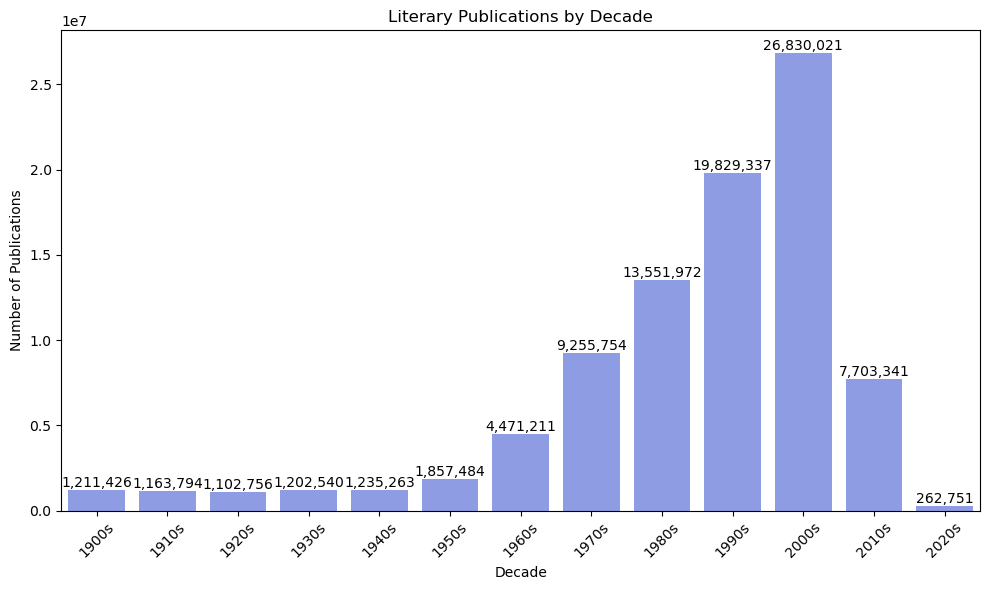

In [41]:
# Visualization 1: Publications per Decade
import os
os.chdir("/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/plots")

plt.figure(figsize=(10, 6))
sns.barplot(x="decade", y="count", data=decade_dist_pd, color='#8093F1')
for i, row in decade_dist_pd.iterrows():
    plt.text(i, row["count"], f"{int(row['count']):,}", ha="center", va="bottom")
plt.title("Literary Publications by Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Publications")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("decade_dist.png")
plt.show()

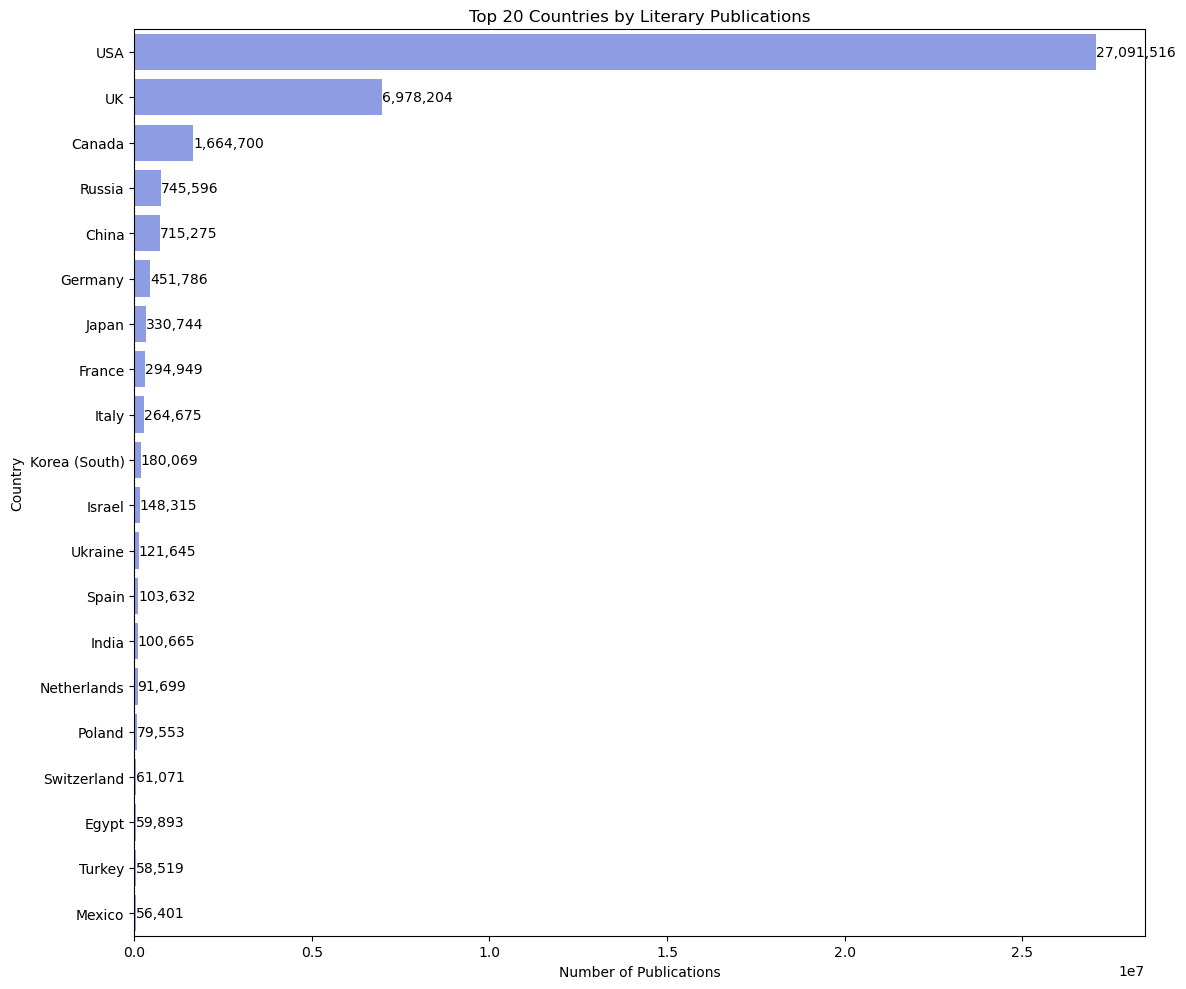

In [42]:
# Visualization 2: Top 20 Countries by Publications
plt.figure(figsize=(12, 10))
sns.barplot(x="count", y="country", data=country_dist_pd, color='#8093F1')
for i, row in country_dist_pd.iterrows():
    plt.text(row["count"], i, f"{int(row['count']):,}", va="center")
plt.title("Top 20 Countries by Literary Publications")
plt.xlabel("Number of Publications")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig("country_dist.png")
plt.show()

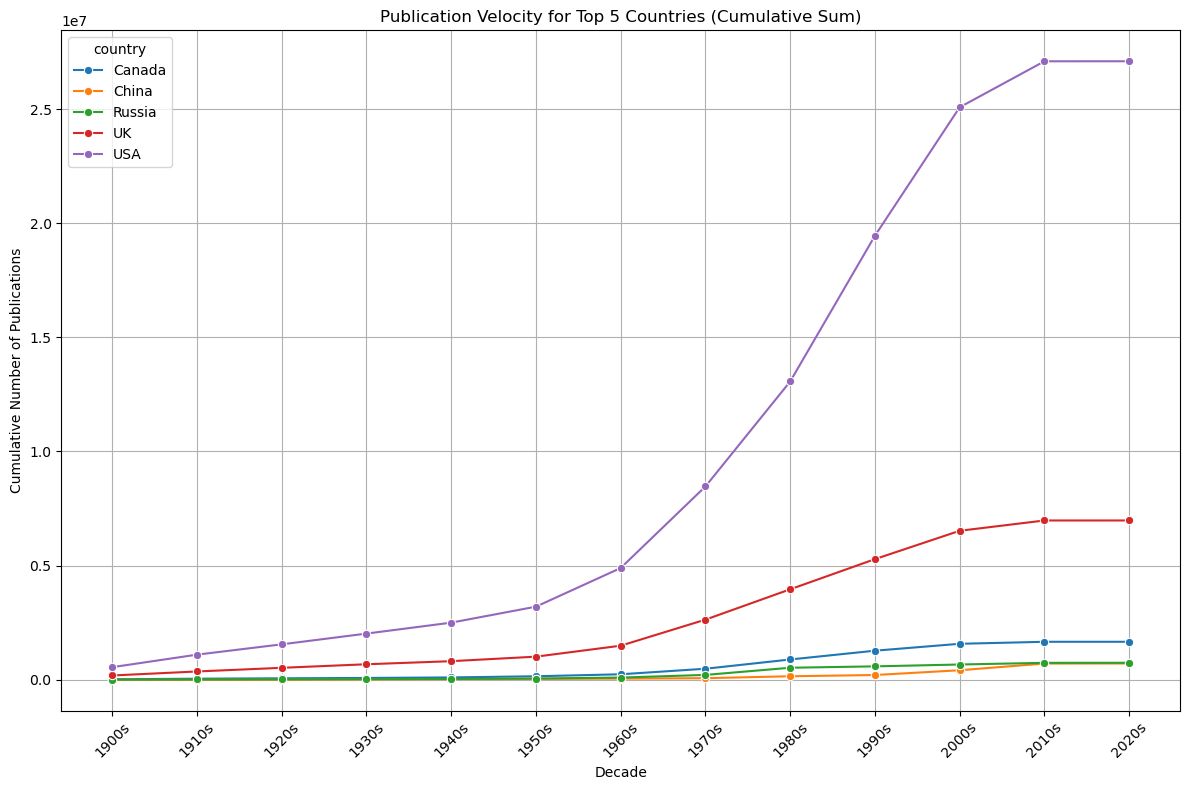

In [44]:
# Visualization 3: Publication Velocity for Top 5 Countries
plt.figure(figsize=(12, 8))
top_5_velocity = top_20_velocity_pd[top_20_velocity_pd["country"].isin(top_5_countries)]
sns.lineplot(x="decade", y="cumulative_count", hue="country", marker="o", data=top_5_velocity)
plt.title("Publication Velocity for Top 5 Countries (Cumulative Sum)")
plt.xlabel("Decade")
plt.ylabel("Cumulative Number of Publications")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("top_20_velocity.png")
plt.show()

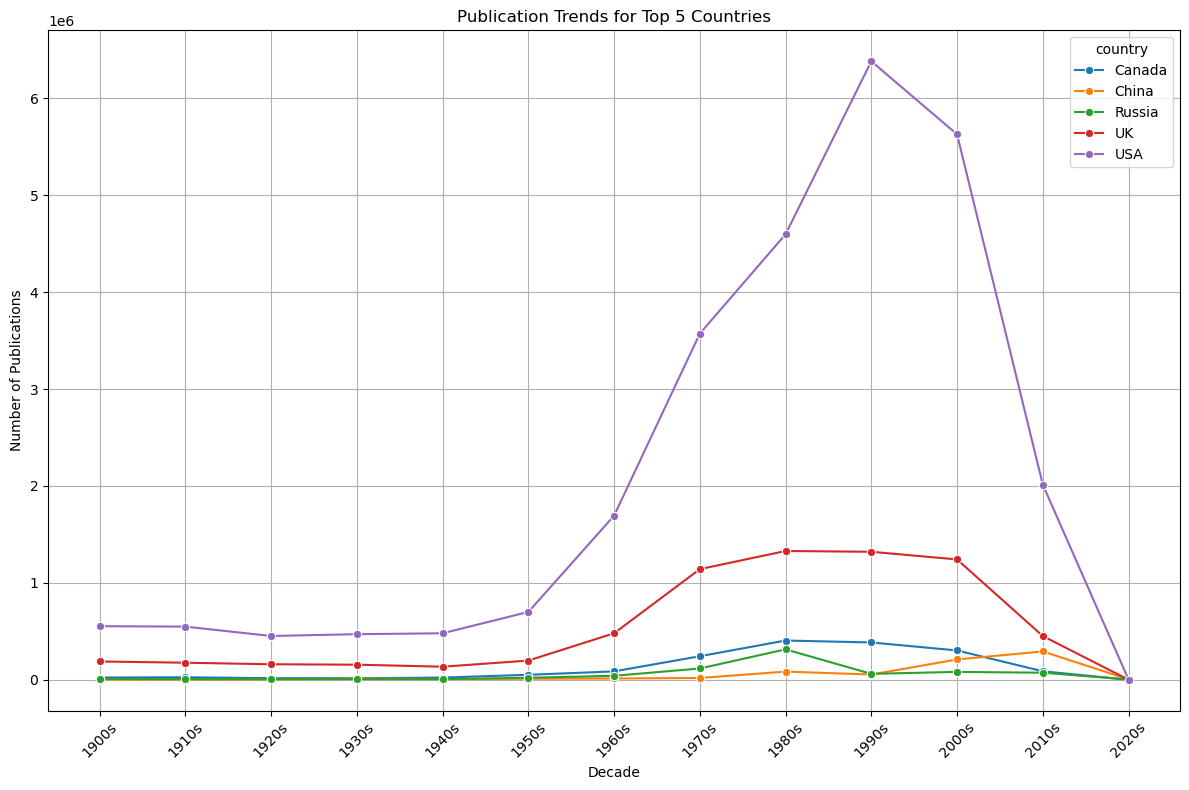

In [25]:
# Visualization 4: Top 5 Countries' Publication Trends
plt.figure(figsize=(12, 8))
sns.lineplot(x="decade", y="count", hue="country", marker="o", data=top_5_trends_pd)
plt.title("Publication Trends for Top 5 Countries")
plt.xlabel("Decade")
plt.ylabel("Number of Publications")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("top_5_trends.png")
plt.show()

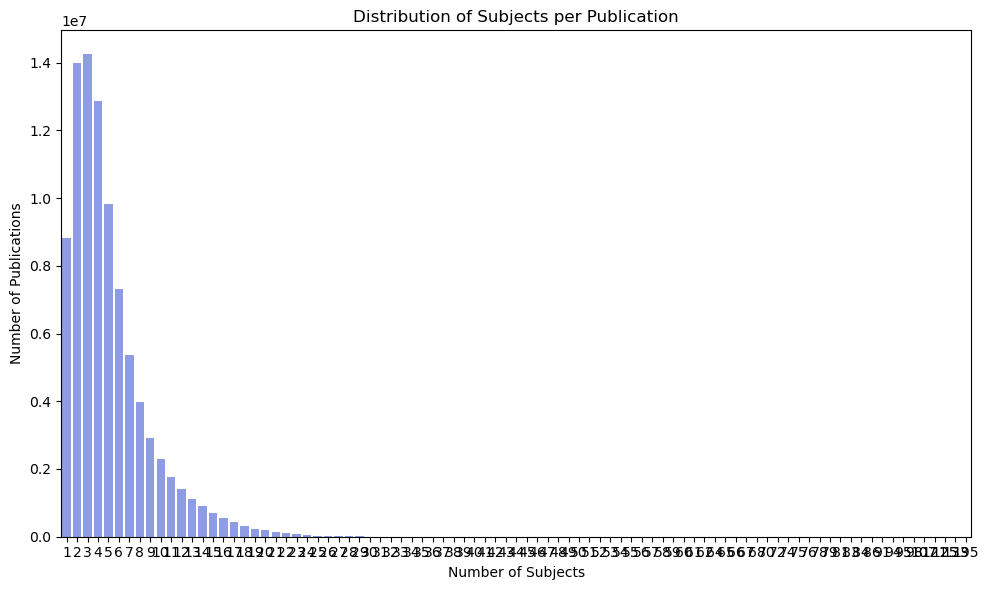

In [45]:
# Visualization 5: Distribution of Subjects per Publication
plt.figure(figsize=(10, 6))
sns.barplot(x="subject_count", y="count", data=subject_count_dist_pd, color='#8093F1')
# for i, row in subject_count_dist_pd.iterrows():
#     plt.text(i, row["count"], f"{int(row['count'])}", ha="center", va="bottom")
plt.title("Distribution of Subjects per Publication")
plt.xlabel("Number of Subjects")
plt.ylabel("Number of Publications")
plt.tight_layout()
plt.savefig("subject_count_dist.png")
plt.show()

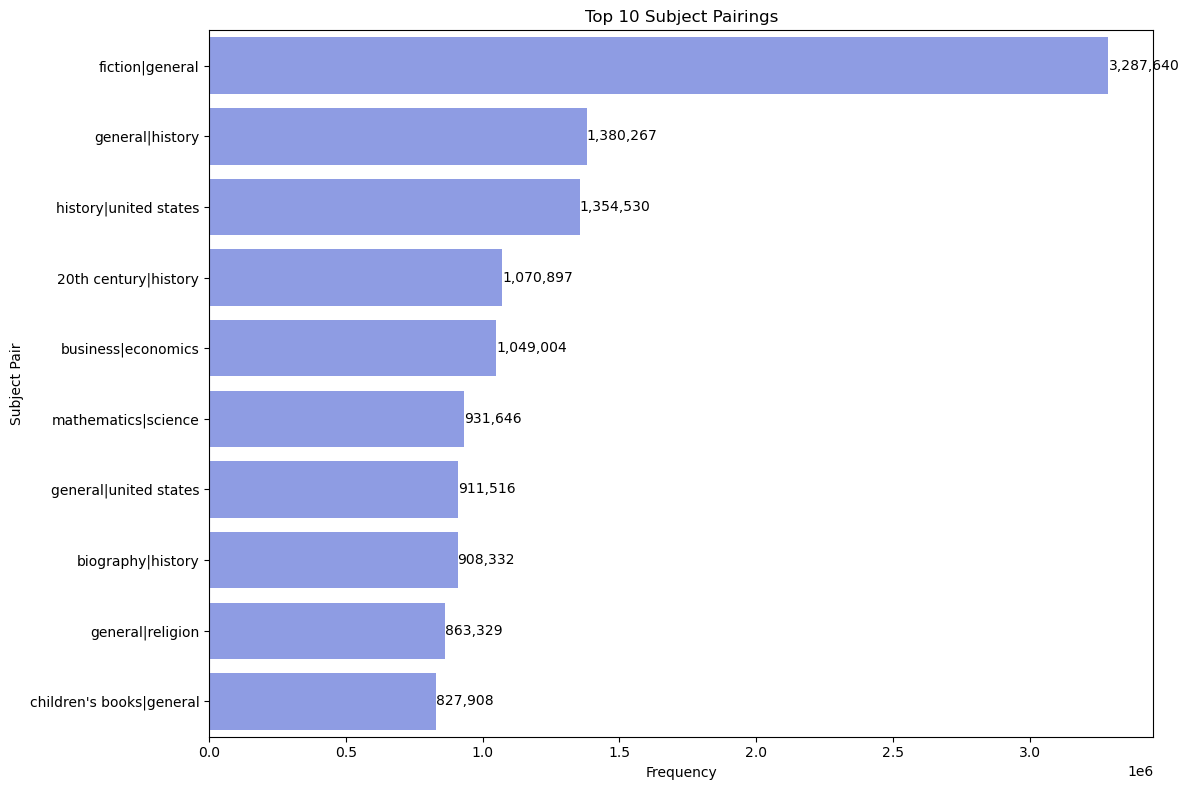

In [46]:
# Visualization 6: Top Subject Pairings
plt.figure(figsize=(12, 8))
# top_pairs_pd["items_str"] = top_pairs_pd["items"].apply(lambda x: ", ".join(x))
sns.barplot(x="count", y="pair", data=top_pairs_pd.head(10), color='#8093F1')
for i, row in top_pairs_pd.head(10).iterrows():
    plt.text(row["count"], i, f"{int(row['count']):,}", va="center")
plt.title("Top 10 Subject Pairings")
plt.xlabel("Frequency")
plt.ylabel("Subject Pair")
plt.tight_layout()
plt.savefig("top_pairs.png")
plt.show()

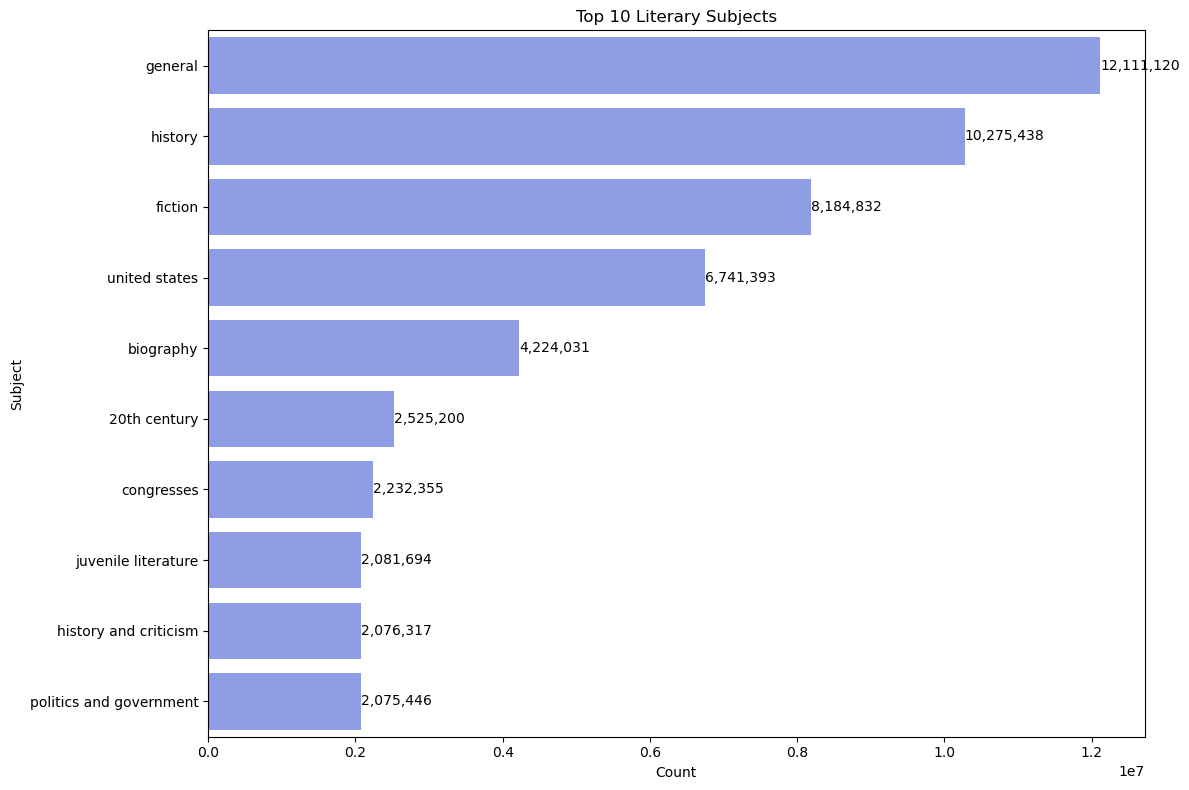

In [47]:
# Visualization 7: Top 10 Subjects Overall
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="subject", data=top_subjects_pd.head(10), color='#8093F1')
for i, row in top_subjects_pd.head(10).iterrows():
    plt.text(row["count"], i, f"{int(row['count']):,}", va="center")
plt.title("Top 10 Literary Subjects")
plt.xlabel("Count")
plt.ylabel("Subject")
plt.tight_layout()
plt.savefig("top_subjects.png")
plt.show()

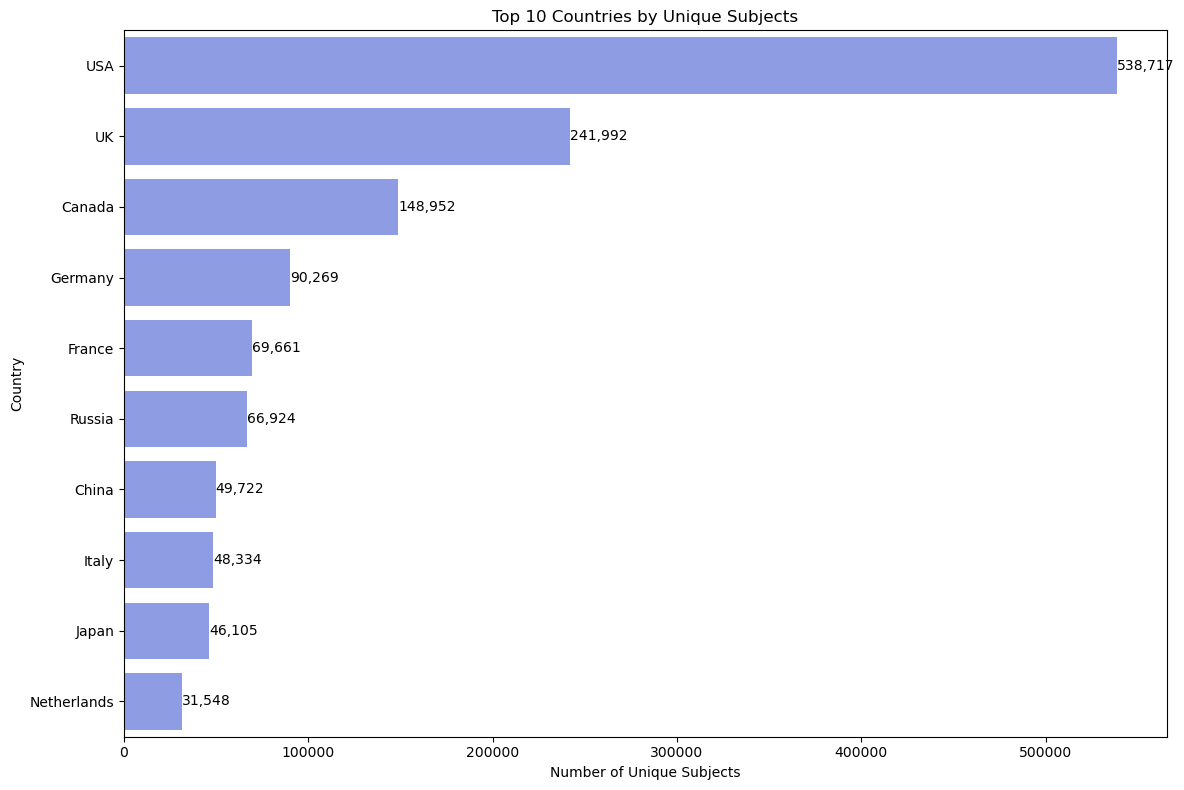

In [48]:
# Visualization 8: Unique Subjects per Country
plt.figure(figsize=(12, 8))
sns.barplot(x="unique_subjects", y="country", data=unique_subjects_country_pd.head(10), color='#8093F1')
for i, row in unique_subjects_country_pd.head(10).iterrows():
    plt.text(row["unique_subjects"], i, f"{int(row['unique_subjects']):,}", va="center")
plt.title("Top 10 Countries by Unique Subjects")
plt.xlabel("Number of Unique Subjects")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig("unique_subjects_country.png")
plt.show()

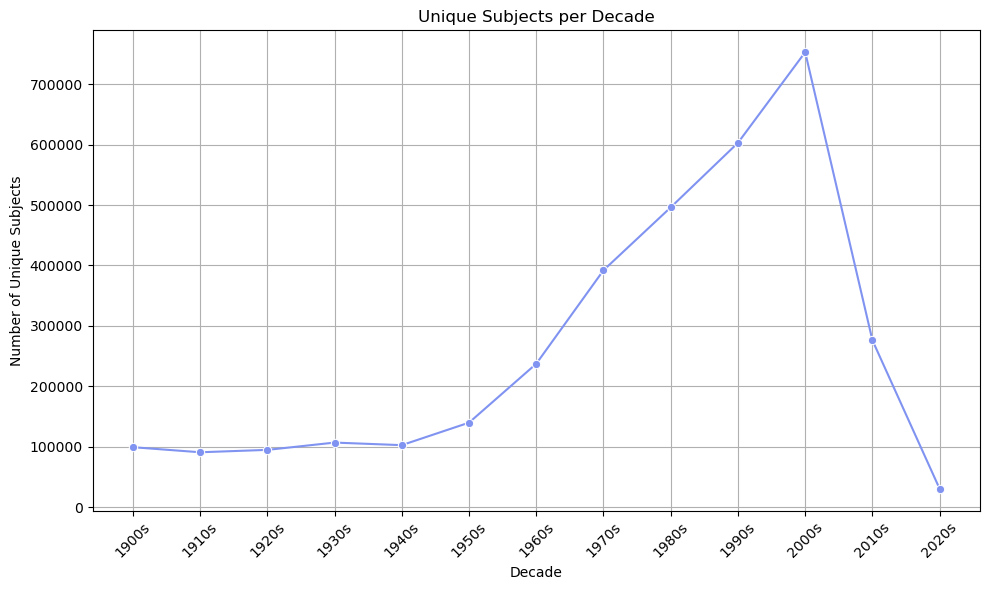

In [49]:
# Visualization 9: Unique Subjects per Decade
plt.figure(figsize=(10, 6))
sns.lineplot(x="decade", y="unique_subjects", data=unique_subjects_decade_pd, marker="o", color='#8093F1')
plt.title("Unique Subjects per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Unique Subjects")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("unique_subjects_decade.png")
plt.show()

In [38]:
# Visualization 10: Choropleth Map of Publications
country_counts = country_dist_pd[["country", "count"]]
fig = px.choropleth(
    country_counts,
    locations="country",
    locationmode="country names",
    color="count",
    hover_name="country",
    color_continuous_scale="Viridis",
    title="Literary Publications by Country"
)
fig.update_layout(geo=dict(showframe=False, projection_type="equirectangular"))
fig.write_html("country_output_map.html")

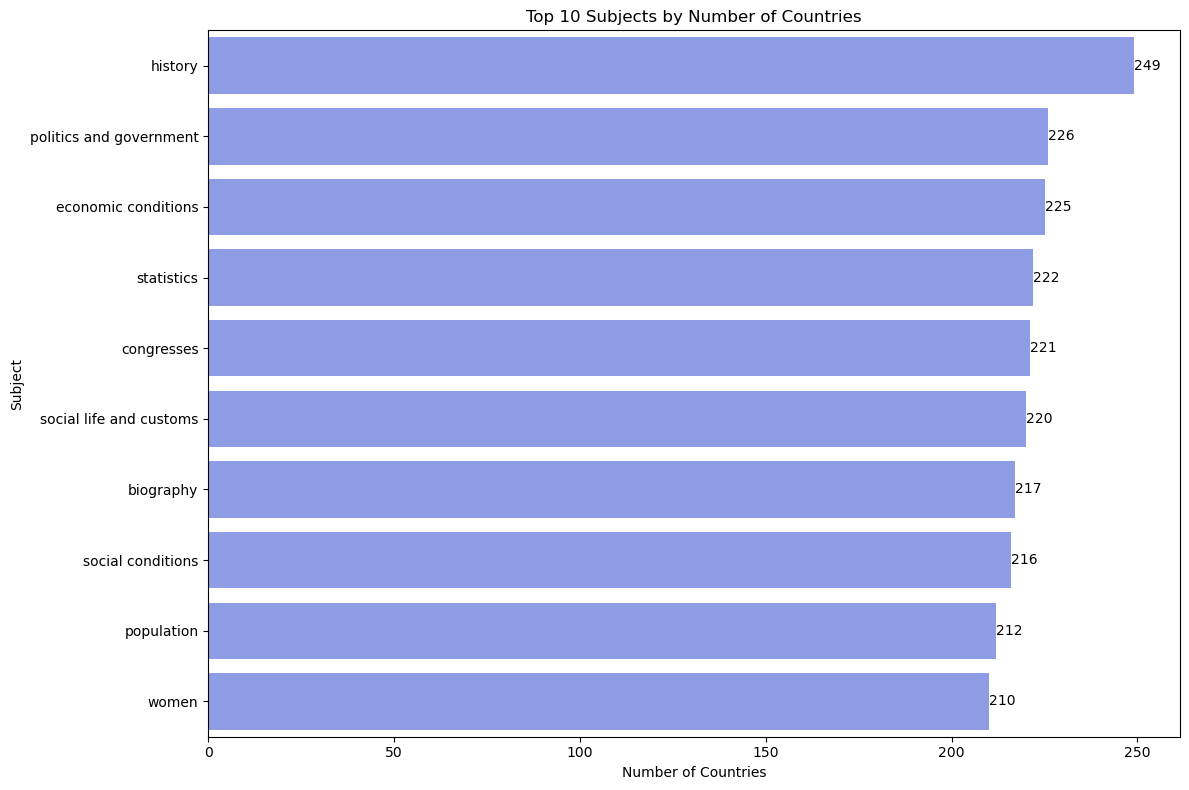

In [50]:
# Visualization 11: Subjects by Number of Countries
plt.figure(figsize=(12, 8))
sns.barplot(x="num_countries", y="subject", data=subject_countries_pd.head(10), color='#8093F1')
for i, row in subject_countries_pd.head(10).iterrows():
    plt.text(row["num_countries"], i, f"{int(row['num_countries'])}", va="center")
plt.title("Top 10 Subjects by Number of Countries")
plt.xlabel("Number of Countries")
plt.ylabel("Subject")
plt.tight_layout()
plt.savefig("subject_countries.png")
plt.show()